Волатильность цены — это показатель того, насколько сильно и быстро меняется цена на товар за определенный период. В контексте авиационных запчастей для S7 это насколько предсказуема стоимость деталей.

Низкая волатильность: Цена стабильна, ее легко прогнозировать.
Высокая волатильность: Цена «скачет» вверх-вниз из-за курса валют, дефицита сырья или изменения логистических цепочек.

Как волатильность влияет на закупки?
При высокой волатильности трудно предсказать, сколько денег потребуется на закупки через полгода. Риск не вписаться в бюджет возрастает.
При стабильных ценах хороши фиксированные контракты.
При волатильных ценах часто используют форвардные контракты(форвардный контракт — это твердая договоренность купить товар (например, авиадвигатель или партию запчастей) в будущем, но по цене, которую вы зафиксировали сегодня.).

In [ ]:
import pandas as pd
df_orders = pd.read_csv('final_orders_train.csv')
df_cons = pd.read_csv('final_consumtion_train.csv')

## Первичный анализ датасетов

In [12]:
df_cons

,consumtion_id,consumtion_date,product_id,product_category,qty
0,0,2020-01-01,73,3,4.0
1,1,2020-01-01,73,3,2.0
2,2,2020-01-01,73,3,5.0
3,3,2020-01-01,73,3,5.0
4,4,2020-01-01,73,3,4.0
...,...,...,...,...,...
82763,78391,2025-08-31,73,3,9.0
82764,78392,2025-08-31,73,3,1.0
82765,78393,2025-08-31,73,3,1.0
82766,78394,2025-08-31,73,3,1.0


In [29]:
df_orders

,order_id,product_category,product_id,order_date,delivery_date,amount,qty,valid_delivered_qty
0,0,4,61,2020-01-02,2020-01-14,1.249730e+05,1.0,1.0
1,1,4,58,2020-01-04,2020-01-14,1.202992e+06,4.0,4.0
2,2,0,12,2020-02-04,2020-02-19,3.010961e+06,5.0,5.0
3,3,4,46,2020-03-17,2020-03-29,5.144759e+06,25.0,12.0
4,4,4,50,2020-04-16,2020-04-16,6.565086e-01,1.0,1.0
...,...,...,...,...,...,...,...,...
1802,1837,4,50,2025-01-17,NaN,4.060958e+05,2.0,NaN
1803,1838,4,48,2025-01-17,NaN,1.094812e+06,10.0,NaN
1804,1839,4,48,2025-01-17,NaN,2.189625e+05,2.0,NaN
1805,1889,2,106,2025-04-03,NaN,1.121301e+06,6.0,NaN


Интересный момент, количество consumtion_id меньше количества строк, значит есть строки с одиноковым id. Найдем их

In [7]:
id_counts = df_cons['consumtion_id'].value_counts()
id_counts[id_counts > 1]

consumtion_id
44116    160
28666    105
28669     80
78102     80
47604     79
        ... 
75147      2
75979      2
76337      2
76733      2
77802      2
Name: count, Length: 353, dtype: int64

In [8]:
duplicates = df_cons[df_cons.duplicated(subset=['consumtion_id'], keep=False)]
duplicates_sorted = duplicates.sort_values(by='consumtion_id')

duplicates_sorted.head(10)

,consumtion_id,consumtion_date,product_id,product_category,qty
562,562,2020-01-23,50,4,2.0
563,562,2020-01-23,0,4,1.0
930,929,2020-02-09,1,4,1.0
931,929,2020-02-09,26,4,1.0
2019,2017,2020-04-09,32,4,2.0
2020,2017,2020-04-09,50,4,1.0
3506,3503,2020-09-08,73,3,4.0
3507,3503,2020-09-08,73,3,2.0
3714,3710,2020-09-24,110,2,3.0
3715,3710,2020-09-24,112,2,1.0


Скорее всего это ошибка и транзакции разбили на несколько, объеденим транзакции с одинаковым id вместе

In [18]:
df_cons = df_cons.groupby('consumtion_id').agg({
    'consumtion_date':'first',
    'product_id':'first',
    'product_category':'first',
    'qty':'sum'
})
df_cons

,consumtion_date,product_id,product_category,qty
consumtion_id,,,,
0,2020-01-01,73,3,4.0
1,2020-01-01,73,3,2.0
2,2020-01-01,73,3,5.0
3,2020-01-01,73,3,5.0
4,2020-01-01,73,3,4.0
...,...,...,...,...
78391,2025-08-31,73,3,9.0
78392,2025-08-31,73,3,1.0
78393,2025-08-31,73,3,1.0


In [19]:
df_cons.to_csv('cleaned_consumption.csv', index=True, encoding='utf-8-sig')

## Анализ волатильности категорий

In [33]:
df_orders

,order_id,product_category,product_id,order_date,delivery_date,amount,qty,valid_delivered_qty
0,0,4,61,2020-01-02,2020-01-14,1.249730e+05,1.0,1.0
1,1,4,58,2020-01-04,2020-01-14,1.202992e+06,4.0,4.0
2,2,0,12,2020-02-04,2020-02-19,3.010961e+06,5.0,5.0
3,3,4,46,2020-03-17,2020-03-29,5.144759e+06,25.0,12.0
4,4,4,50,2020-04-16,2020-04-16,6.565086e-01,1.0,1.0
...,...,...,...,...,...,...,...,...
1802,1837,4,50,2025-01-17,NaN,4.060958e+05,2.0,NaN
1803,1838,4,48,2025-01-17,NaN,1.094812e+06,10.0,NaN
1804,1839,4,48,2025-01-17,NaN,2.189625e+05,2.0,NaN
1805,1889,2,106,2025-04-03,NaN,1.121301e+06,6.0,NaN


In [130]:
def get_price(num_categ: int) -> pd.Series:
    categ = df_orders[df_orders['product_category'] == num_categ]
    price = categ["amount"] / categ["qty"]
    return price

Медианная и средняя цена каждой категории

In [131]:
for i in range(5):
    price_mean = get_price(i).mean()
    price_median = get_price(i).median()
    div = abs(price_mean - price_median)
    print(
        f"categ:{i} средняя цена = {price_mean:.0f}    мединная цена = {price_median:.0f}     разница = {div:.0f}({(div * 100) / ((price_median + price_mean) / 2):.0f}%)"
    )

categ:0 средняя цена = 1877666    мединная цена = 1984443     разница = 106777(6%)
categ:1 средняя цена = 20785999    мединная цена = 5799904     разница = 14986095(113%)
categ:2 средняя цена = 163687    мединная цена = 149743     разница = 13944(9%)
categ:3 средняя цена = 2461    мединная цена = 1930     разница = 531(24%)
categ:4 средняя цена = 242321    мединная цена = 199134     разница = 43187(20%)


pandas.Series

Стандартное отклонение и cv

In [140]:
import numpy as np
def volatility():
    for i in range(5):
        price = get_price(i).to_numpy()
        std = np.std(price)
        cv = std / np.mean(price)
        print(f'Категория: {i} Стандартное отклонение = {std:.2f}    CV={cv:.2f}')
    print('CV - коэффициент вариации, если цены разных масштабов(удобно сравнивать категории)')
volatility()

Категория: 0 Стандартное отклонение = 547359.38    CV=0.29
Категория: 1 Стандартное отклонение = 26645921.32    CV=1.28
Категория: 2 Стандартное отклонение = 79157.17    CV=0.48
Категория: 3 Стандартное отклонение = 932.24    CV=0.38
Категория: 4 Стандартное отклонение = 166129.90    CV=0.69
CV - коэффициент вариации, если цены разных масштабов(удобно сравнивать категории)


Популярность категории т.е сколько строк с этой категории есть в датасете. 

In [27]:
df_orders['product_category'].value_counts()

product_category
4    953
2    683
0     81
3     78
1     12
Name: count, dtype: int64

Товары 1-ой категории редко заказывали значит точность волатильности цены не высокая(это надо запомнить) 

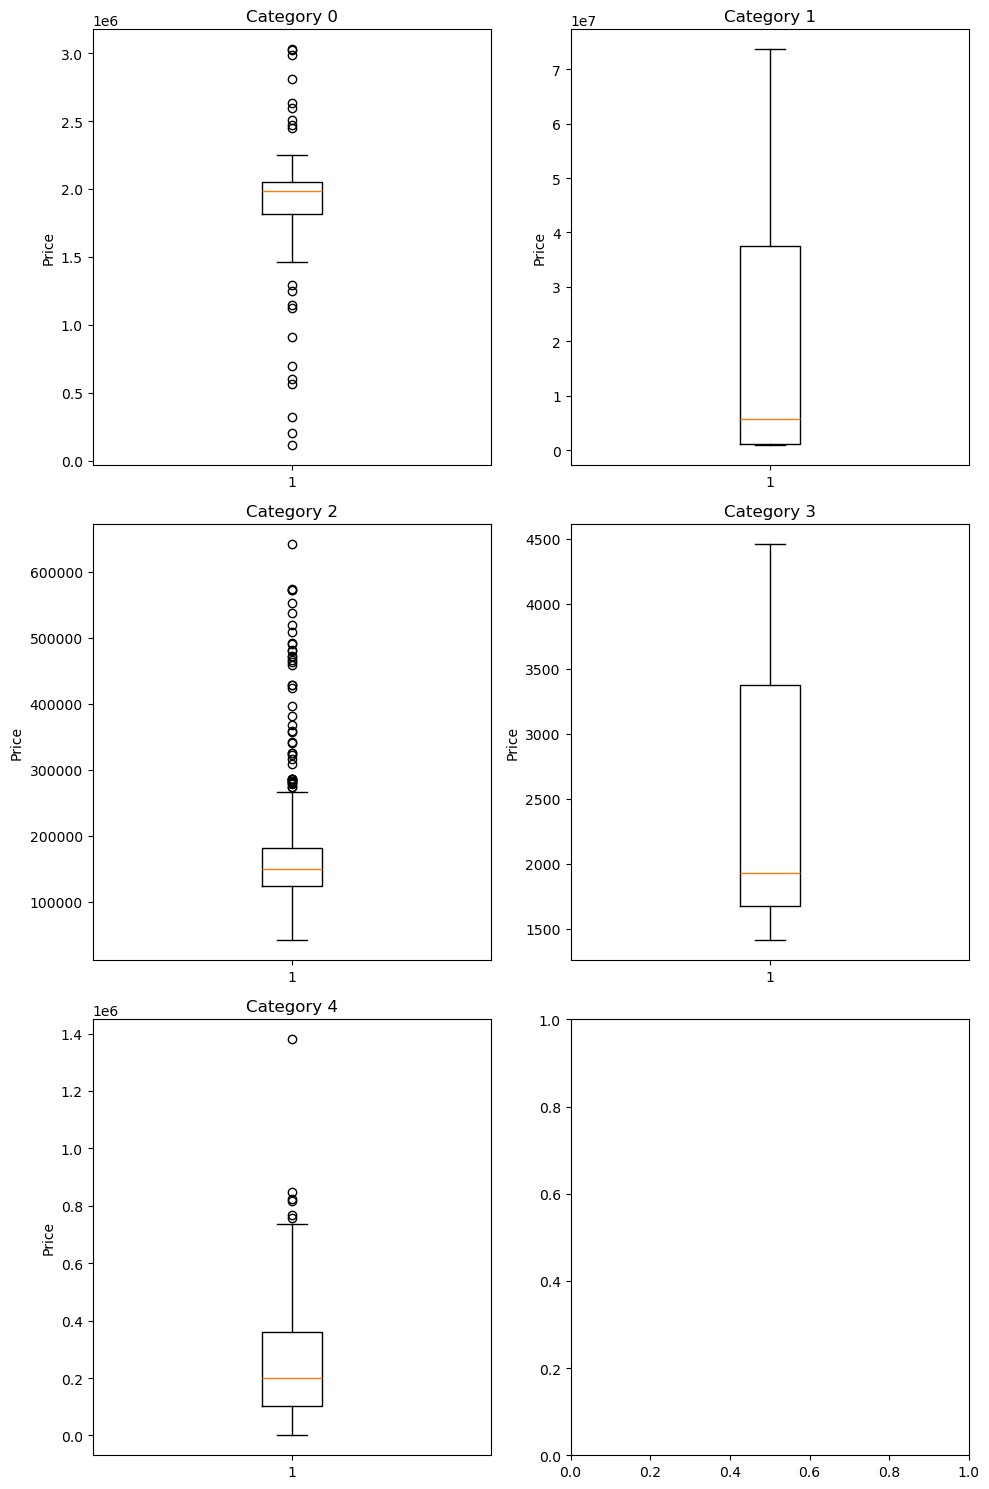

In [79]:
import matplotlib.pyplot as plt

_, axes = plt.subplots(3, 2, figsize=(10, 15))

axes = axes.flatten()

for i in range(5):
    prices = get_price(i)
    
    axes[i].boxplot(prices)
    axes[i].set_title(f"Category {i}")
    axes[i].set_ylabel("Price")

plt.tight_layout()
plt.show()

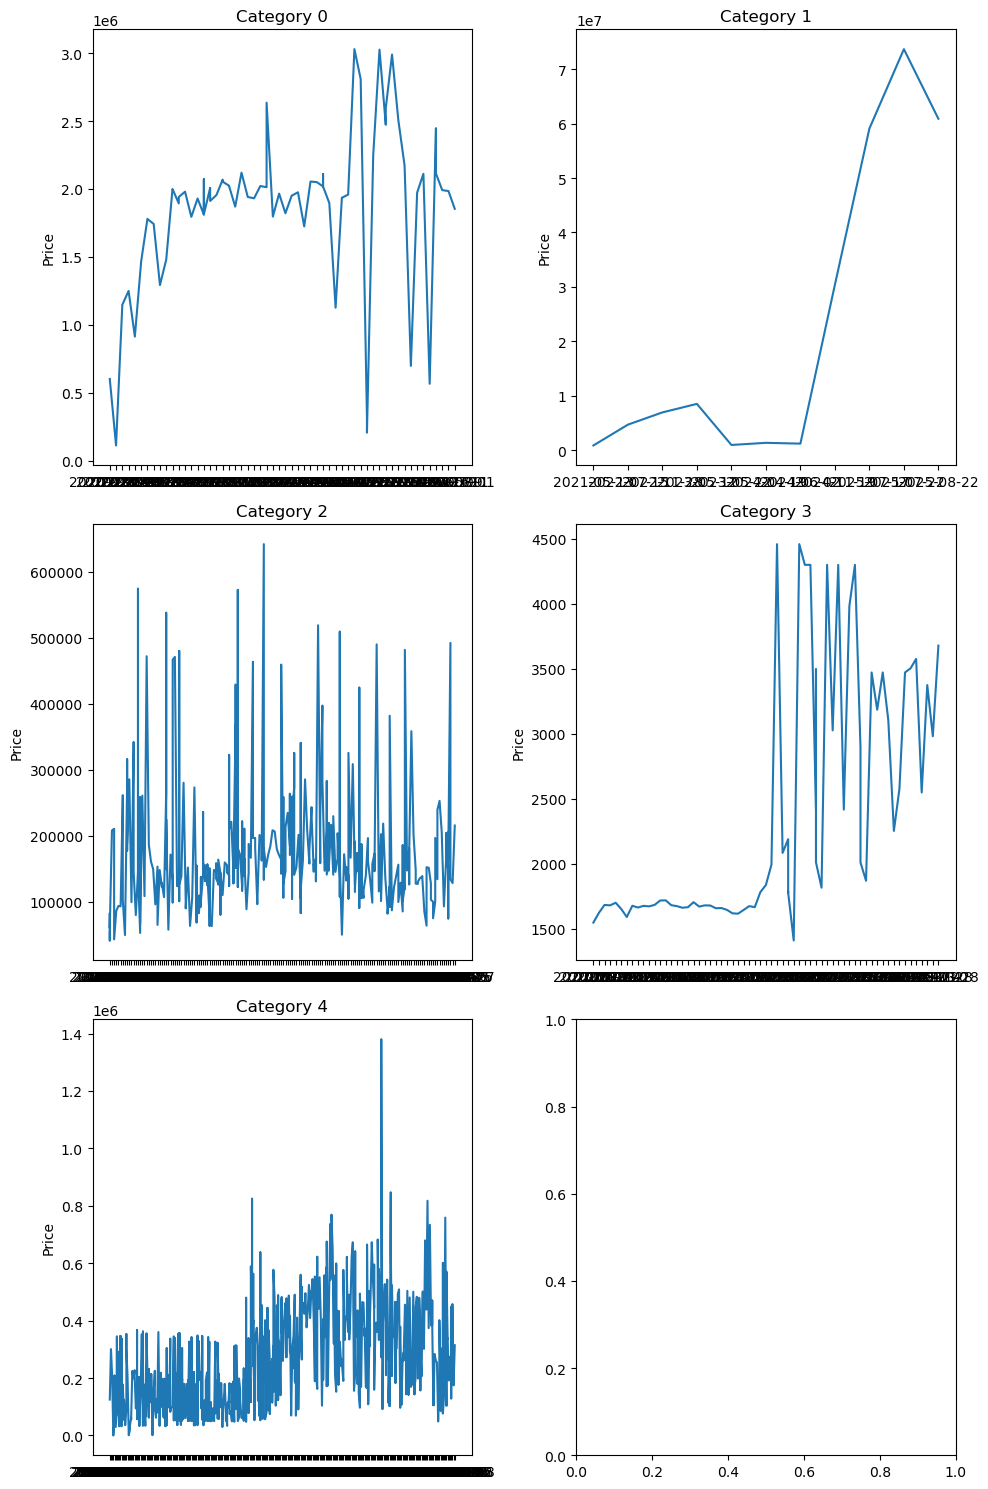

In [97]:
_, axes = plt.subplots(3, 2, figsize=(10, 15))

axes = axes.flatten()
df_orders = df_orders.sort_values('order_date')
for i in range(5):
    prices = get_price(i)
    
    axes[i].plot(df_orders[df_orders['product_category']==i]['order_date'], get_price(i).to_numpy())
    axes[i].set_title(f"Category {i}")
    axes[i].set_ylabel("Price")

plt.tight_layout()
plt.show()

Добавим колонку unit_price

In [132]:
df_orders["unit_price"] = df_orders["amount"] / df_orders["qty"]

In [134]:
df_orders.to_csv('orders_with_unitPrice.csv', index=True, encoding='utf-8-sig')

In [137]:
df_orders

,order_id,product_category,product_id,order_date,delivery_date,amount,qty,valid_delivered_qty,unit_price
0,0,4,61,2020-01-02,2020-01-14,1.249730e+05,1.0,1.0,1.249730e+05
1,1,4,58,2020-01-04,2020-01-14,1.202992e+06,4.0,4.0,3.007480e+05
2,2,0,12,2020-02-04,2020-02-19,3.010961e+06,5.0,5.0,6.021923e+05
3,3,4,46,2020-03-17,2020-03-29,5.144759e+06,25.0,12.0,2.057904e+05
4,4,4,50,2020-04-16,2020-04-16,6.565086e-01,1.0,1.0,6.565086e-01
...,...,...,...,...,...,...,...,...,...
1789,1789,1,5,2025-08-22,NaN,6.090192e+07,1.0,NaN,6.090192e+07
1791,1791,2,80,2025-08-25,NaN,1.870615e+07,38.0,NaN,4.922671e+05
1790,1790,2,76,2025-08-25,NaN,1.341970e+05,1.0,NaN,1.341970e+05
1793,1793,2,75,2025-08-26,NaN,1.285337e+05,1.0,NaN,1.285337e+05


Уберем выбросы и посчитам cv без них

In [143]:
def get_clean_mask(group):
    q1 = group['unit_price'].quantile(0.25)
    q3 = group['unit_price'].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return (group['unit_price'] >= lower) & (group['unit_price'] <= upper)

mask = df_orders.groupby('product_category')['unit_price'].transform(lambda x: get_clean_mask(pd.DataFrame({'unit_price': x})))
df_clean_prices = df_orders[mask].copy()

new_volatility = df_clean_prices.groupby('product_category')['unit_price'].agg(['mean', 'std']).reset_index()
new_volatility['new_cv'] = new_volatility['std'] / new_volatility['mean']

volatility()
print("\nМетрики после удаления выбросов:")
new_volatility

Категория: 0 Стандартное отклонение = 547359.38    CV=0.29
Категория: 1 Стандартное отклонение = 26645921.32    CV=1.28
Категория: 2 Стандартное отклонение = 79157.17    CV=0.48
Категория: 3 Стандартное отклонение = 932.24    CV=0.38
Категория: 4 Стандартное отклонение = 166129.90    CV=0.69
CV - коэффициент вариации, если цены разных масштабов(удобно сравнивать категории)

Метрики после удаления выбросов:


,product_category,mean,std,new_cv
0,0,1.956445e+06,1.377576e+05,0.070412
1,1,2.078600e+07,2.783076e+07,1.338918
2,2,1.476790e+05,4.342844e+04,0.294073
3,3,2.460743e+03,9.382696e+02,0.381295
4,4,2.381565e+05,1.573096e+05,0.660530


**Вывод**: Хотя графики цены закупок по дате и CV создали впечатления невероятной волатильности, но boxplot показал нам что сильные колебания вызваны выбросами, а в общем случае волатильность есть но с этим можно как-то работать.

**Категория 1:**
Категория катастрофически неоднородна. Также данных по ней мало, этот товар заказывают несколько раз в год.
**Рекомендация:** Переход на стратегию «Закупка под потребность». Нельзя держать такие дорогие и непредсказуемые вещи на складе про запас — это заморозит миллионы.

**Категории 0, 2 и 4:**
Волатильность здесь "искусственная", она создается этими редкими выбросами. Основная масса товаров в этих категориях предсказуема. Выбросы это либо разовые закупки супер-дорогих агрегатов, либо экстренные заказы.
**Рекомендация:** Считать волатильность по медиане, а не по среднему. В модели закупок нужно игнорировать эти выбросы при планировании обычного стока. Если игнорировать выбросы, то **категория 0** стала очень предсказуемой по цене, можно смело заключать годовые контракты с фиксированной ценой. **Категория 2** со средней, контролируемой волатильностью, для этой категории подходят среднесрочные рамочные договоры с фиксацией цен в определенном коридоре, что защитит бюджет от редких выбросов.
**Категория 4** аналогична категории 3 но более волатильная .

**Категория 3:**
Это самая предсказуемая категория. Несмотря на CV в 38%, она лучше всего поддается классическому.
**Рекомендация:** Здесь нужно динамическое управление запасами и большой страховой запас.

In [23]:
import pandas as pd
import numpy as np

A = 55
a = [22, 11, 20, 14, 5, 19, 15, 11]
c = [1, 2, 3, 4, 5, 6, 7, 8]
max_c = sum(c)
len_c = len(c)

Q = pd.DataFrame(np.inf * np.ones((max_c, len(c))))
X = pd.DataFrame(np.inf * np.ones((max_c, len(c))))

for y in range(1, max_c):
    if y <= c[0]:
        Q.iloc[0,y] = a[0]
        X.iloc[0,y] = 1
for k in range(len_c):
    Q.iloc[k,0] = 0
    X.iloc[k,0] = 0


In [25]:
import pandas as pd
import numpy as np

A = 55
a = [12, 2, 16, 19, 14, 28, 19, 22] # Веса из картинки
c = [1, 2, 3, 4, 5, 6, 7, 8]       # Стоимости
max_c = sum(c) + 1
len_c = len(c)

# Создаем таблицу: строки - предметы (len_c), столбцы - стоимость (max_c)
Q = pd.DataFrame(np.inf, index=range(len_c), columns=range(max_c))
X = pd.DataFrame(0, index=range(len_c), columns=range(max_c))

# Инициализация для первого предмета (индекс 0)
Q.iloc[0, 0] = 0
if c[0] < max_c:
    Q.iloc[0, c[0]] = a[0]
    X.iloc[0, c[0]] = 1

# Заполнение для остальных предметов
for k in range(1, len_c):
    Q.iloc[k, 0] = 0 # Вес для нулевой стоимости всегда 0
    for y in range(max_c):
        # Вариант 1: Не берем предмет k
        res_not_take = Q.iloc[k - 1, y]
        
        # Вариант 2: Берем предмет k (если стоимость y позволяет)
        res_take = np.inf
        if y >= c[k]:
            res_take = a[k] + Q.iloc[k - 1, y - c[k]]
        
        # Выбираем минимальный вес для текущей стоимости y
        if res_take < res_not_take:
            if res_take <= A: # Проверка на ограничение вместимости
                Q.iloc[k, y] = res_take
                X.iloc[k, y] = 1
            else:
                Q.iloc[k, y] = np.inf # Вес слишком велик
        else:
            Q.iloc[k, y] = res_not_take
            X.iloc[k, y] = 0

# Ищем максимальный индекс y, где вес не np.inf
result_cost = Q.iloc[len_c - 1][Q.iloc[len_c - 1] <= A].index.max()
print(f"Максимальная стоимость: {result_cost}")

Максимальная стоимость: 20


In [24]:
t = 0
for k in range(1, len_c):
    for y in range(1, max_c):
        t = a[k] + Q.iloc[k - 1, max(0, y - c[k])]

        if t < Q.iloc[k - 1, y]:
            if t > A:
                break
            else:
                Q.iloc[k, y] = t
                X.iloc[k, y] = 1
        else:
            if Q.iloc[k - 1, y] > A:
                break
            else:
                Q.iloc[k, y] = Q.iloc[k - 1, y]
                X.iloc[k, y] = 0

IndexError: index 8 is out of bounds for axis 0 with size 8

In [49]:
Q.iloc[:,19:]

,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
0,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
1,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
3,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
4,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
5,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
6,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
7,inf,55.0,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [44]:
X.iloc[:,2:]

,2,3,4,5,6,7,8,9,10,11,...,27,28,29,30,31,32,33,34,35,36
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
x_opt = [0]*(len(c))
y = max_c-1
len_c-=1

while(Q.iloc[len_c,y]==np.inf): 
    y-=1  
    print(y)
    for k in range(len_c, -1, -1):
        if X.iloc[k,y]==0: 
            continue
        x_opt[k] = 1
        y-=c[k]
        print(k+1, y)

35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
7 11
5 6
4 2
2 0


In [53]:
x_opt

[0, 1, 0, 1, 1, 0, 1, 0]